<a href="https://colab.research.google.com/github/priti378/synthetic_seismogram1/blob/main/synthetic_seismogram_with_attenuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from numpy import append, arange, array, repeat
from matplotlib import pyplot
from math import pi, exp

Reflection coefficient for boundary 1 : 0.2
Travel time in case of reflection from boundary 1 : 400.0 ms
Attenuation factor in layer 1 is : 0.9998429327036801

Transmission coefficient for layer 1 to layer 2 : 1.2
Transmission coefficient for layer 2 to layer 1 : 0.8
Reflection coefficient for boundary 2 : 0.14285714285714285
Travel time in case of reflection from boundary 2 : 413.3333333333333 ms
Attenuation factor in layer 2 is : 0.9999972074770959

Transmission coefficient for layer 2 to layer 3 : 1.1428571428571428
Transmission coefficient for layer 3 to layer 2 : 0.8571428571428571
Reflection coefficient for boundary 3 : -0.1111111111111111
Travel time in case of reflection from boundary 3 : 433.33333333333337 ms
Attenuation factor in layer 3 is : 0.9999973820095489

Transmission coefficient for layer 3 to layer 4 : 0.8888888888888888
Transmission coefficient for layer 4 to layer 3 : 1.1111111111111112
Reflection coefficient for boundary 4 : 0.21951219512195122
Travel time in case

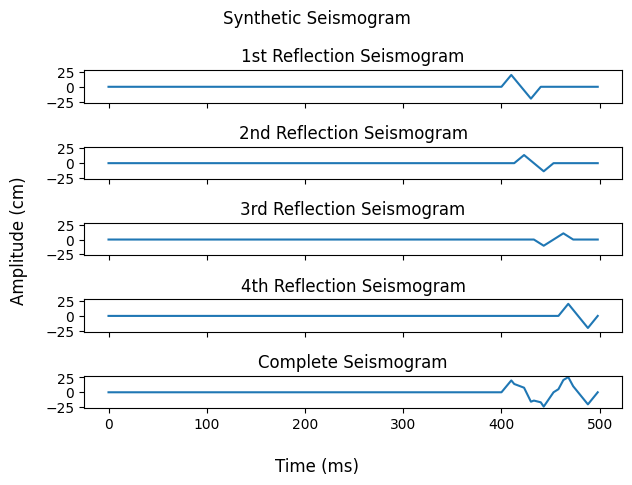

In [4]:
def syntheticWaveGenerator(maxReflectionBoundaryNo, sourceWaveAmplitudes, sourceWaveTimeInterval, layerHeights, layerVelocities, layerDensities, qualityFactors):

    def calcReflectionCoeff(boundaryNo):
        ro1v1 = layerDensities[boundaryNo-1]*layerVelocities[boundaryNo-1]
        ro2v2 = layerDensities[boundaryNo]*layerVelocities[boundaryNo]

        refCoeff = (ro2v2-ro1v1)/(ro2v2+ro1v1)
        print(f"Reflection coefficient for boundary {boundaryNo} : {refCoeff}")

        return refCoeff

    def calcTransmissionCoeff(incidentLayerNo, transmittedLayerNo):
        ro1v1 = layerDensities[incidentLayerNo-1]*layerVelocities[incidentLayerNo-1]
        ro2v2 = layerDensities[transmittedLayerNo-1]*layerVelocities[transmittedLayerNo-1]

        transCoeff = 2*ro2v2/(ro2v2+ro1v1)
        print(f"Transmission coefficient for layer {incidentLayerNo} to layer {transmittedLayerNo} : {transCoeff}")

        return transCoeff

    def calcTravelTime(reflectionBoundaryNo):

        travelTime = 0
        for i in range(0, reflectionBoundaryNo):
            travelTime += 2*layerHeights[i]/layerVelocities[i]

        print(f"Travel time in case of reflection from boundary {reflectionBoundaryNo} : {travelTime*1000} ms")
        return travelTime

    def calcAttenuationFactor(reflectionBoundaryNo):

        alpha = pi*(1/((len(sourceWaveAmplitudes)-1)*sourceWaveTimeInterval))/(qualityFactors[reflectionBoundaryNo-1]*layerVelocities[reflectionBoundaryNo-1])
        attenuationFactor = exp(-alpha*(travelTimes[reflectionBoundaryNo-1]-(travelTimes[reflectionBoundaryNo-2] if reflectionBoundaryNo>1 else 0)))

        print(f"Attenuation factor in layer {reflectionBoundaryNo} is : {attenuationFactor}")
        return attenuationFactor

    finalSeismogram = array([0.0])
    reflectionsSeismogram = [array([0.0]) for i in range(maxReflectionBoundaryNo)]

    travelTimes = [0 for x in range(maxReflectionBoundaryNo)]
    prevAttenuationFactor = 1;

    for i in range(1, maxReflectionBoundaryNo+1):

        refCoeff = calcReflectionCoeff(i)
        travelTimes[i-1] = calcTravelTime(i)
        attenuationFactor = calcAttenuationFactor(i)*prevAttenuationFactor

        reflectionsSeismogram[i-1] = append(
            repeat(array([0.0]), round(travelTimes[i-1]/sourceWaveTimeInterval)),
            sourceWaveAmplitudes*refCoeff*attenuationFactor
        )

        prevAttenuationFactor = attenuationFactor

        finalSeismogram = append(finalSeismogram, repeat(array([0.0]), len(reflectionsSeismogram[i-1])-len(finalSeismogram)))
        finalSeismogram += reflectionsSeismogram[i-1]

        print("")
        sourceWaveAmplitudes *= calcTransmissionCoeff(i,i+1)*calcTransmissionCoeff(i+1,i)

    return finalSeismogram, reflectionsSeismogram

finalSeismogram, reflectionsSeismogram = syntheticWaveGenerator(
    maxReflectionBoundaryNo = 4,
    sourceWaveAmplitudes = array([
        0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6,
        0.5, 0.4, 0.3, 0.2, 0.1, 0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7,
        -0.8, -0.9, -1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0
    ]),
    sourceWaveTimeInterval = 0.001,
    layerHeights = [200, 10, 20, 20],
    layerVelocities = [1000, 1500, 2000, 1600, 2500],
    layerDensities = [1, 1, 1, 1, 1],
    qualityFactors = [200, 250, 300, 250]
)

T = arange(0, len(finalSeismogram))

fig, axs = pyplot.subplots(4+1, sharex = True, sharey = True)
fig.suptitle('Synthetic Seismogram')
fig.supxlabel("Time (ms)")
fig.supylabel("Amplitude (cm)")

ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])
for i in range(len(reflectionsSeismogram)):
    reflectionsSeismogram[i] = append(reflectionsSeismogram[i], repeat(array([0.0]), len(T)-len(reflectionsSeismogram[i])))
    axs[i].plot(T, 100*reflectionsSeismogram[i])
    axs[i].set_title(f"{ordinal(i+1)} Reflection Seismogram")

axs[4].plot(T, 100*finalSeismogram)
axs[4].set_title("Complete Seismogram")

fig.tight_layout()
pyplot.show()